# Chapter 23. Principal Components Analysis

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from numpy.fft import fft, ifft
from scipy.signal import filtfilt

import mne
from mne.externals.pymatreader import read_mat

In [8]:
data = scipy.io.loadmat('sampleEEGdata')
EEGdata = data["EEG"][0,0]["data"]
EEGpnts = data["EEG"][0,0]["pnts"][0,0] #number of points in EEG data
EEGtimes = data["EEG"][0,0]["times"][0]
EEGsrate = float(data["EEG"][0,0]["srate"][0]) #make float for division purposes later
EEGtrials = data["EEG"][0,0]["trials"][0,0]
EEGnbchan = data["EEG"][0,0]["nbchan"][0,0]
EEGchanlocslabels=data["EEG"][0,0]["chanlocs"][0]["labels"]

In [10]:
# load data using MNE
data_in = read_mat('C:/users/micha/analyzing_neural_time_series/sampleEEGdata.mat')
EEG = data_in['EEG']

# get channel location info
coords_2d = np.column_stack([EEG['chanlocs']['Y'], EEG['chanlocs']['X']])

### Figure 23.2

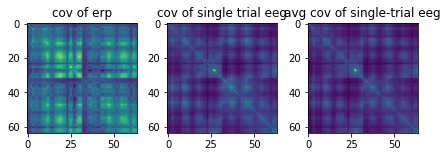

In [6]:
# compute erp, subtract mean, compute cov
erp = EEGdata.mean(2).squeeze()
erp -= erp.mean(1)[:, np.newaxis]

covar = (erp @ erp.T)/(EEGpnts - 1)  # unbiased

fig, ax = plt.subplots(1,3)
im0 = ax[0].imshow(covar)
ax[0].set(title='cov of erp')

# one cov of all time points
eeg = np.reshape(EEGdata, (EEGnbchan, EEGpnts*EEGtrials), order='f')
eeg -= eeg.mean(1)[:, np.newaxis]
covar = np.cov(eeg)
im1 = ax[1].imshow(covar)
ax[1].set(title='cov of single trial eeg')

# avg of single trial covs
covar = np.zeros(EEGnbchan)
for i in range(EEGtrials):
    eeg = EEGdata[...,i] - EEGdata[...,i].mean(1)[:, np.newaxis]
    covar = covar + np.cov(eeg)

covar /= i
ax[2].imshow(covar)
ax[2].set(title='avg cov of single-trial eeg')

fig.tight_layout()

### Figure 23.3

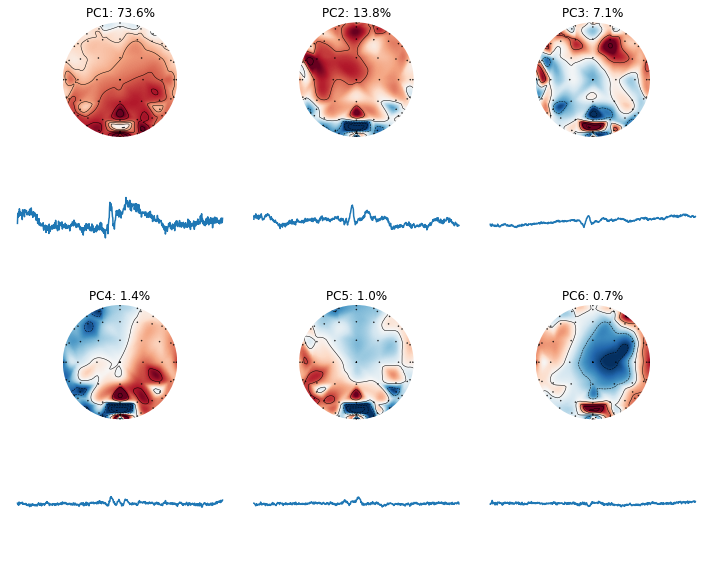

In [11]:
# PCA for ERP (Figure 23.3 A)

# calc ERP - average activity over trials
erp = EEGdata.mean(2)

# subtract mean activity from each channel
erp_min_mean = np.zeros_like(erp)
for ii in range(EEGnbchan):
    erp_min_mean[ii] = erp[ii] - erp[ii].mean()

# compute covariance matrix (normalize by # of samples - 1)
covar_erp = (erp @ erp.T)/(EEGpnts - 1)

# perform eigendecomposition
eig_val_erp, eig_erp = np.linalg.eig(covar_erp)
  
# compute PC time-series
pc_erp = eig_erp.T @ erp_min_mean

# calculate variance explained
var_explained_erp = 100 * eig_val_erp / eig_val_erp.sum()

# plot results
nrows = 4
ncols = 3
fig, ax = plt.subplots(nrows, ncols, figsize=[10,8], sharey=True, tight_layout=True)

# loop through first 6 PCs
for ii in range(int(nrows*ncols/2)):
    # determine subplot indices
    row = 2 * int(np.floor(ii/ncols))
    col = int(ii - ncols*np.floor(ii/ncols))

    # plot time-series
    ax[row+1][col].plot(pc_erp[ii])
    ax[row+1][col].set_axis_off()

    # plot topo of eigenvectors
    mne.viz.plot_topomap(eig_erp[:,ii], coords_2d, axes=ax[row][col], show=False)
    ax[row][col].set_title("PC%d: %0.1f%%" %(ii+1, var_explained_erp[ii]))
plt.show()

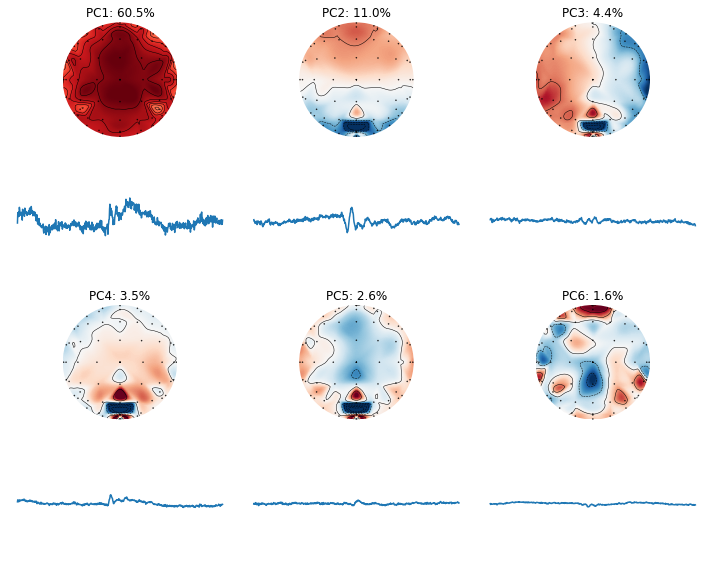

In [12]:
# PCA of single-trial EEG (Figure 23.3 B)

# initialize covariance matrix
covar_trial = np.zeros([EEGnbchan, EEGnbchan, EEGdata.shape[2]])
eeg_min_mean = np.zeros_like(EEGdata)

# loop through trial data
for ii in range(EEGtrials):
     # subtract mean from each channel
    for jj in range(EEGnbchan):
        eeg_min_mean[jj,:,ii] = EEGdata[jj,:,ii] - EEGdata[jj,:,ii].mean()
      
    # calc covariance for trial
    covar_trial[..., ii] = np.cov(eeg_min_mean[..., ii])

# average covaraiance over trials
covar = np.mean(covar_trial, axis=2)

# perform eigendecomposition
eig_val, eig = np.linalg.eig(covar)

# compute PC time-series
pc_trial = np.zeros_like(eeg_min_mean)
for ii in range(EEGtrials):
    pc_trial[..., ii] = eig.T @ eeg_min_mean[..., ii]
pc = pc_trial.mean(2)
    
# calculate percent explained variance
var_explained = 100 * eig_val / eig_val.sum()

# plot results
nrows = 4
ncols = 3
fig, ax = plt.subplots(nrows, ncols, figsize=[10,8], sharey=True, tight_layout=True)

# loop trough first few PCs
for ii in range(int(nrows*ncols/2)):
    # determine subplot indices
    row = 2*int(np.floor(ii/ncols))
    col = int(ii - ncols*np.floor(ii/ncols))
    
    # plot PC time-series
    ax[row+1][col].plot(pc[ii])
    ax[row+1][col].set_axis_off()
    
    # plot topo of eigenvectors
    mne.viz.plot_topomap(eig[:,ii], coords_2d, axes=ax[row][col], show=False)
    ax[row][col].set_title('PC%d: %0.1f%%' %(ii+1, var_explained[ii]))
    
plt.show()

### Figure 23.4
Also needs topoplot

### Figure 23.5

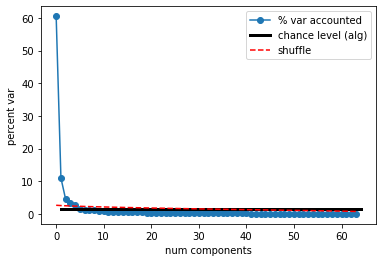

In [81]:
covar = np.zeros((EEGnbchan, EEGnbchan))

for i in range(EEGtrials):
    eeg = EEGdata[...,i] - EEGdata[...,i].mean(1)[:,np.newaxis]
    covar = covar + np.cov(eeg)

covar = covar/i

pc, eigvals, _ = np.linalg.svd(covar)
eigvals = 100*eigvals/sum(eigvals)

plt.plot(eigvals, '-o', label='% var accounted')
plt.plot([1, EEGnbchan], [100/EEGnbchan]*2, 'k', label='chance level (alg)', linewidth=3)

# amount of var expected by chance computed based on rand data
nperms = 100
permeigvals = np.zeros((nperms, EEGnbchan))

for permi in range(nperms):
    randdat = np.random.permutation(erp.flatten())
    randdat = np.reshape(randdat, (EEGnbchan, EEGpnts))
    covar = np.cov(randdat)
    pc, eigvals,_ = np.linalg.svd(covar)
    permeigvals[permi] = 100*eigvals/sum(eigvals)

plt.plot(permeigvals.mean(0), 'r--', label='shuffle')
plt.xlabel('num components')
plt.ylabel('percent var')
plt.legend()

### Figure 23.6, 23.7
Also requires topoplot

In [19]:

center_freq = 12
filter_frequency_spread = 3
transition_width = 0.2

# construct kernel
nyquist = EEGsrate/2
filter_order = int(3*(EEGsrate/(center_freq - filter_frequency_spread)))
ffrequencies = np.array([0,
                        (1-transition_width)*(center_freq-filter_frequency_spread),
                        (center_freq - filter_frequency_spread),
                        (center_freq + filter_frequency_spread),
                        (1 + transition_width)*(center_freq+filter_frequency_spread),
                        nyquist])/nyquist
idealresponse = [0, 0, 1, 1, 0, 0]
filterweights = scipy.signal.firls(filter_order, list(ffrequencies), idealresponse)

filter_result = scipy.signal.filtfilt(filterweights, 1,
                                      np.reshape(EEGdata, (EEGnbchan, EEGpnts* EEGtrials), order='f'))
filter_result = np.reshape(filter_result, (EEGnbchan, EEGpnts, EEGtrials), 'F')

### Figure 23.8

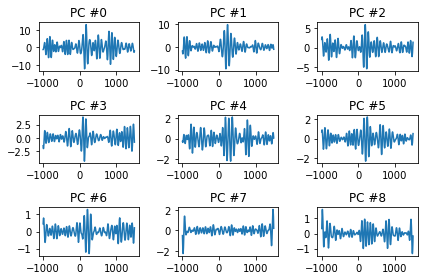

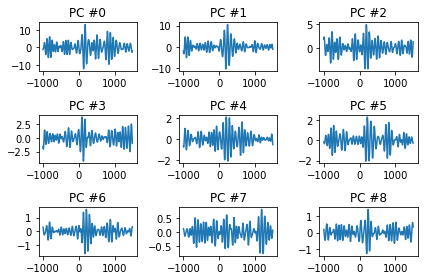

In [28]:
covar = np.zeros(EEGnbchan)
for i in range(30):
    eeg = filter_result[...,i] - filter_result[...,0].mean(1)[:, np.newaxis]
    covar = covar + np.cov(eeg)
covar /= i

pc, eigvals, _ = np.linalg.svd(covar)

fig, ax = plt.subplots(3,3)
for i in range(9):
   idx = np.unravel_index(i, (3,3))
   ax[idx].plot(EEGtimes, pc[:,i]@filter_result[...,:30].mean(2))
   ax[idx].set(title=f'PC #{i}')
fig.tight_layout()

# pca on last 30 trials
covar = np.zeros((EEGnbchan, EEGnbchan))
for i in range(EEGtrials-30, EEGtrials):
    eeg = filter_result[...,i] - filter_result[...,i].mean(1)[:,np.newaxis]
    covar = covar + np.cov(eeg)
covar /= 30

pc, eigvals, _ = np.linalg.svd(covar)

fig, ax = plt.subplots(3,3)
for i in range(9):
   idx = np.unravel_index(i, (3,3))
   ax[idx].plot(EEGtimes, pc[:,i]@filter_result[...,:30].mean(2))
   ax[idx].set(title=f'PC #{i}')
fig.tight_layout()
